In [49]:
import os
from typing import Tuple, List, Sequence, Callable

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [18]:
df = pd.read_csv('./1. open/train_df.csv')
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


In [43]:
def draw_keypoints(image: np.ndarray, keypoints: np.ndarray, edges: List[Tuple[int, int]]) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}
    x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
    x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        cv2.putText(
            image, 
            f'{i}: {keypoint_names[i]}', 
            tuple(keypoint), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    for i, edge in enumerate(edges):
        cv2.line(
            image, 
            tuple(keypoints[edge[0]]), 
            tuple(keypoints[edge[1]]),
            colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=200)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')

In [44]:
train = pd.read_csv('./1. open/train.csv')
valid = pd.read_csv('./1. open/valid.csv')

train_paths = glob.glob('./1. open/train/*.jpg')
valid_paths = glob.glob('./1. open/valid/*.jpg')
test_paths = glob.glob('./1. open/test_imgs/*.jpg')
print(len(train_paths), len(valid_paths), len(test_paths))

train_paths.sort()
valid_paths.sort()
test_paths.sort()

train['path'] = train_paths
valid['path'] = valid_paths

3776 419 1600


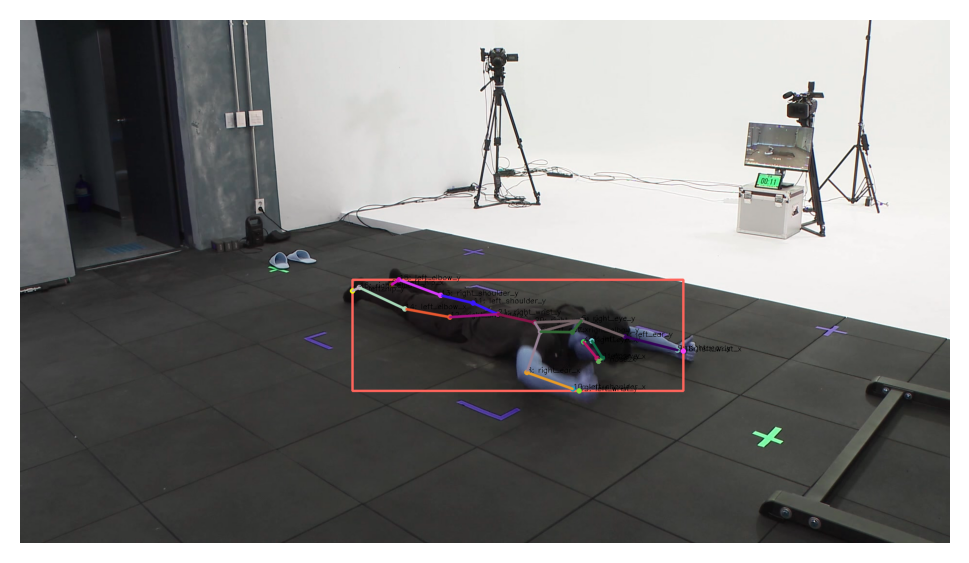

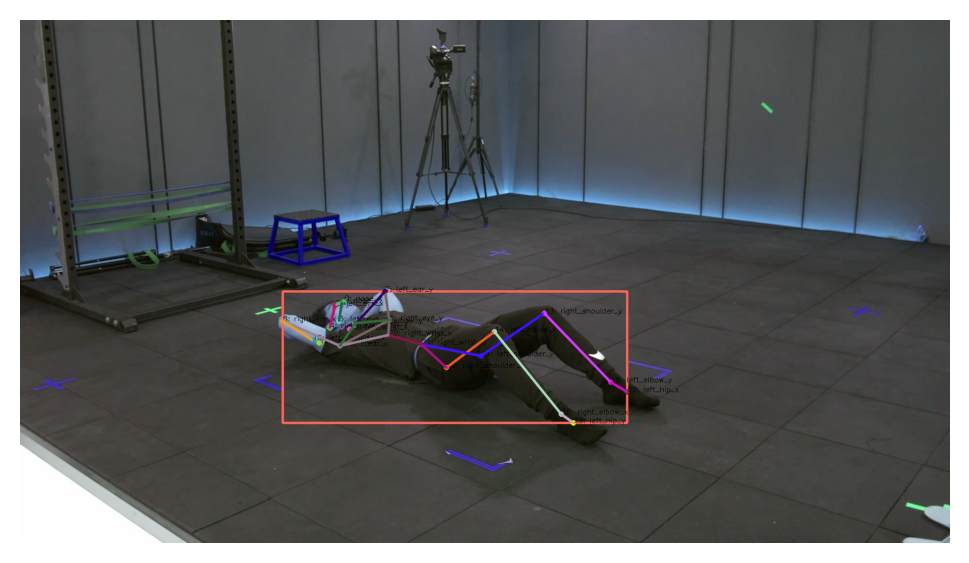

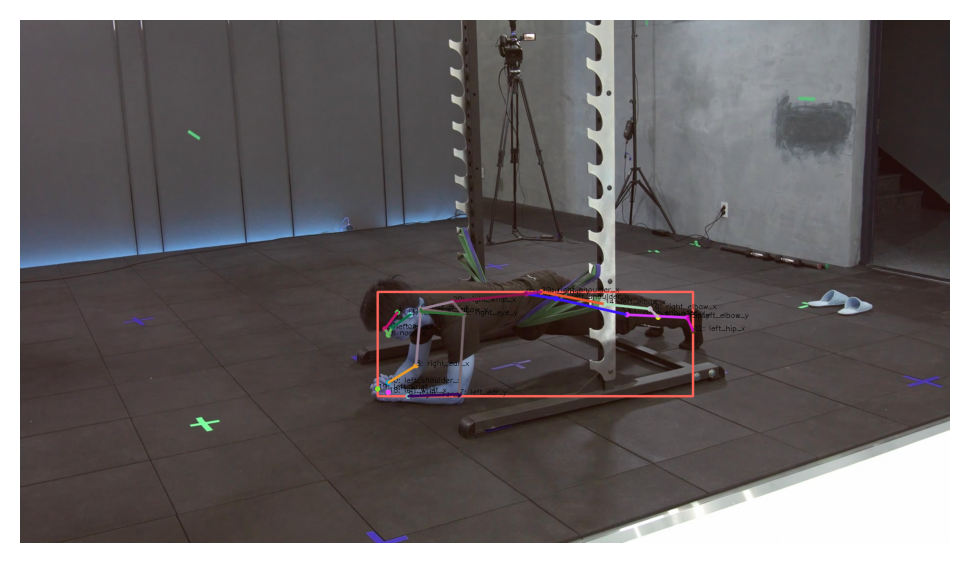

In [45]:
edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (11, 13), (13, 15), (12, 14), 
    (14, 16), (5, 6), (15, 22), (16, 23), (11, 21),
    (21, 12), (20, 21), (5, 20), (6, 20), (17, 6), (17, 5)
]

for i in np.random.randint(0, len(train), 3):
    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :].values.reshape(-1, 2)
    keypoint_sample =  keypoint_sample.astype(np.int64)
    keypoint_names = df.columns[1:].tolist()
    image = cv2.imread(train['path'][i], cv2.COLOR_BGR2RGB)
    draw_keypoints(image, keypoint_sample, edges)

In [50]:
class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_path: os.PathLike,
        transforms: Sequence[Callable]=None
    ) -> None:
        self.image_dir = image_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets


In [65]:
transforms = A.Compose([
    A.Resize(270, 480),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
    keypoint_params=A.KeypointParams(format='xy')
)

In [66]:
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))


trainset = KeypointDataset('./1. open/train_imgs/', './1. open/train_df.csv', transforms)
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [67]:
trainset[0]

(tensor([[[-0.0033, -0.0062, -0.0043,  ..., -0.0017, -0.0015, -0.0015],
          [-0.0054, -0.0013,  0.0015,  ..., -0.0017, -0.0015, -0.0016],
          [-0.0023,  0.0016,  0.0012,  ..., -0.0016, -0.0015, -0.0014],
          ...,
          [ 0.0045,  0.0045,  0.0045,  ...,  0.0028,  0.0032,  0.0032],
          [ 0.0045,  0.0045,  0.0043,  ...,  0.0028,  0.0030,  0.0030],
          [ 0.0043,  0.0043,  0.0043,  ...,  0.0028,  0.0028,  0.0028]],
 
         [[-0.0024, -0.0061, -0.0044,  ...,  0.0010,  0.0013,  0.0013],
          [-0.0059, -0.0013,  0.0022,  ...,  0.0012,  0.0014,  0.0013],
          [-0.0023,  0.0024,  0.0022,  ...,  0.0015,  0.0016,  0.0017],
          ...,
          [ 0.0069,  0.0068,  0.0068,  ...,  0.0040,  0.0041,  0.0040],
          [ 0.0068,  0.0068,  0.0067,  ...,  0.0038,  0.0040,  0.0040],
          [ 0.0067,  0.0067,  0.0067,  ...,  0.0038,  0.0038,  0.0038]],
 
         [[-0.0016, -0.0052, -0.0035,  ...,  0.0023,  0.0026,  0.0026],
          [-0.0049, -0.0003,

In [68]:
def get_model() -> nn.Module:
    backbone = mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [69]:
def train(device='cuda:0'):
    model = get_model()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for i, (images, targets) in enumerate(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            losses = model(images, targets)
    
            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print(f'| epoch: {epoch} | loss: {loss.item():.4f}', end=' | ')
                for k, v in losses.items():
                    print(f'{k[5:]}: {v.item():.4f}', end=' | ')
                print()

In [70]:
train()

RuntimeError: CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 4.00 GiB total capacity; 1.04 GiB already allocated; 221.65 MiB free; 1.08 GiB reserved in total by PyTorch)